<a href="https://colab.research.google.com/github/benmellin/ECG-Prediction/blob/main/BiGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Establish the performance of a Bi-GRU model on ECG heartbeat classification

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
mit_train_df = pd.read_csv("/content/drive/MyDrive/Neural Nets Project/Data/mitbih_train.csv",header=None)
mit_test_df = pd.read_csv("/content/drive/MyDrive/Neural Nets Project/Data/mitbih_test.csv",header=None)

### Compute Class Counts, get weights for NN

In [ ]:
## Class counts
print(mit_train_df[187].value_counts())

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [ ]:
## compute weights
from sklearn.utils.class_weight import compute_class_weight

# Suppose `y_train` is a list or array of your class labels
classes = np.unique(mit_train_df[187])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=mit_train_df[187])

# Convert to torch tensor
class_weights_tensor = torch.tensor(weights, dtype=torch.float32)

In [ ]:
print(class_weights_tensor)

tensor([ 0.2416,  7.8771,  3.0254, 27.3179,  2.7229])


## Drop labels, train test split, convert into dataloader


In [ ]:
## Drop labels, convert to correct shape for model
y_train = mit_train_df[187]
x_train = mit_train_df.drop(mit_train_df.columns[187], axis=1)


y_test = mit_test_df[187]
x_test=mit_test_df.drop(mit_test_df.columns[187],axis=1)



In [ ]:
print(mit_train_df.shape)
print(y_train.shape)

print(mit_test_df.shape)
print(y_test.shape)

(87554, 188)
(87554,)
(21892, 188)
(21892,)


In [ ]:
# Train Test Split to get the validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(x_test.shape)

(21892, 187)


In [ ]:
#convert into data loader
from torch.utils.data import TensorDataset, DataLoader

#train
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_train_tensor = X_train_tensor.view(-1, 187, 1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# Create Dataset and DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#validation
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_val_tensor = X_val_tensor.view(-1, 187, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create Dataset and DataLoader
batch_size = 64
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)




#test
X_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
X_test_tensor = X_test_tensor.view(-1, 187, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create Dataset and DataLoader
batch_size = 64
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
for inputs, labels in train_loader:
    print(inputs.shape)  # Should be [batch_size, seq_len, input_size]
    break

torch.Size([64, 187, 1])


## Create a model

In [ ]:
import torch
import torch.nn as nn

class BiGRUClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, num_classes=5):
        super(BiGRUClassifier, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.5,
            batch_first=True,
            bidirectional=True  # <- BiGRU enabled
        )
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)  # hidden_size x 2 for BiGRU
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)  # out: (batch_size, seq_len, hidden_size * 2)
        last_hidden = out[:, -1, :]  # (batch_size, hidden_size * 2)
        normed = self.batch_norm(last_hidden)
        logits = self.fc(normed)
        return logits


In [ ]:
import torch.optim as optim

# Move to GPU if available

weights = torch.tensor(class_weights_tensor)

model = BiGRUClassifier(
    input_size=1,
    hidden_size=128,
    num_layers=2,
    num_classes=5
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

<ipython-input-36-c0f1902c0631>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(class_weights_tensor)


In [ ]:
print(device)

cuda


In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 0.1440
Epoch [2/10], Loss: 0.1449
Epoch [3/10], Loss: 0.1425
Epoch [4/10], Loss: 0.1342
Epoch [5/10], Loss: 0.1247
Epoch [6/10], Loss: 0.1359
Epoch [7/10], Loss: 0.1332
Epoch [8/10], Loss: 0.1114
Epoch [9/10], Loss: 0.1367
Epoch [10/10], Loss: 0.1202


## Checking Accuracy and Class Scores

Validation Accuracy: 93.57%


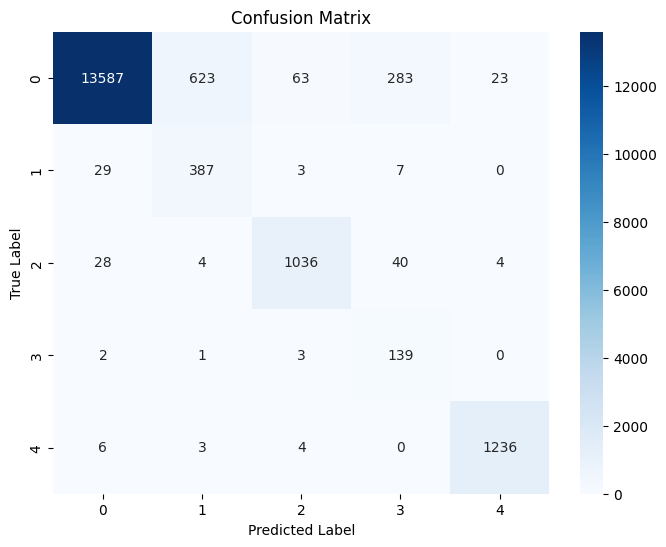

Weighted F1 Score: 0.9476


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions, total samples, and storing predictions
correct = 0
total = 0
all_predictions = []
all_labels = []

# No need to compute gradients during evaluation
with torch.no_grad():
    # Iterate over the validation set
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

        # Forward pass: Get predictions
        outputs = model(inputs)

        # Get the predicted class with the highest probability (i.e., the index of the max value in the output)
        _, predicted = torch.max(outputs, 1)

        # Update the total number of samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for later use in confusion matrix and F1 score
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(5), yticklabels=np.arange(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute weighted F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')


The above was 20 epochs.

## Trying to make the model bigger and see if we can get better performance

In [ ]:
# Move to GPU if available

weights = torch.tensor(class_weights_tensor)

model = BiGRUClassifier(
    input_size=1,
    hidden_size=256,
    num_layers=3,
    num_classes=5
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

<ipython-input-43-8aff3f242c4d>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(class_weights_tensor)


In [ ]:
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 1.4860
Epoch [2/10], Loss: 1.0164
Epoch [3/10], Loss: 0.8443
Epoch [4/10], Loss: 0.7781
Epoch [5/10], Loss: 0.7662
Epoch [6/10], Loss: 0.6626
Epoch [7/10], Loss: 0.6473
Epoch [8/10], Loss: 0.6541
Epoch [9/10], Loss: 1.0819
Epoch [10/10], Loss: 0.9324


Validation Accuracy: 38.28%


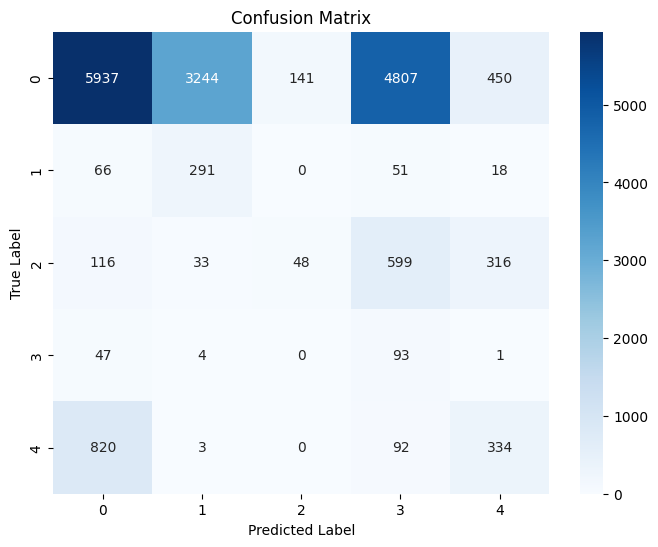

Weighted F1 Score: 0.4870


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
model.eval()

# Initialize variables to track correct predictions, total samples, and storing predictions
correct = 0
total = 0
all_predictions = []
all_labels = []

# No need to compute gradients during evaluation
with torch.no_grad():
    # Iterate over the validation set
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU if available

        # Forward pass: Get predictions
        outputs = model(inputs)

        # Get the predicted class with the highest probability (i.e., the index of the max value in the output)
        _, predicted = torch.max(outputs, 1)

        # Update the total number of samples and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for later use in confusion matrix and F1 score
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(5), yticklabels=np.arange(5))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute weighted F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'Weighted F1 Score: {f1:.4f}')


The larger model didn't seem to work too well.

